<a href="https://colab.research.google.com/github/RAV10K1/DS-Unit-2-Kaggle-Challenge/blob/master/LS_DS_221_Kaggle_Challenge_Decision_Trees_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [2]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [4]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [5]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [9]:
# Splitting Validation data from train dataset.
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.8, test_size=0.2,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((30412, 41), (7604, 41), (14358, 40))

In [10]:
# Checking train data
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
23756,25432,2000.0,2011-03-04,Danida,1434,DANID,36.113735,-7.506559,none,0,Rufiji,Bapulo,Iringa,11,7,Kilolo,Image,600,True,GeoData Consultants Ltd,VWC,kidewa,True,1980,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
53267,59214,500.0,2011-04-04,Adb,1766,DWE,34.557032,-9.151087,Neema Mgalilwa,0,Rufiji,Gonelamafuta,Iringa,11,4,Njombe,Imalinyi,50,True,GeoData Consultants Ltd,WUA,imalinyi water supply schem,True,2009,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
35449,56628,0.0,2013-04-03,Adra,1258,Adra/Community,36.931249,-3.350794,Zadoki,0,Pangani,Mlimani,Arusha,2,7,Meru,Kikatiti,120,True,GeoData Consultants Ltd,VWC,Mambreni gravity water supply,True,2003,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
24913,2031,0.0,2013-02-16,Undp,463,Government,34.936838,-11.452412,Kwa Mzee Msengela,0,Lake Nyasa,Mbuli,Ruvuma,10,3,Mbinga,Chiwanda,80,NaN,GeoData Consultants Ltd,VWC,UNDP,True,2013,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
40712,62715,100.0,2013-03-15,0,70,0,39.076843,-7.005918,Kwa Mama Amada,0,Wami / Ruvu,Mtaa Wa Lubakaya,Dar es Salaam,7,2,Ilala,Chanika,250,NaN,GeoData Consultants Ltd,Private operator,NaN,False,2010,submersible,submersible,submersible,private operator,commercial,pay per bucket,per bucket,salty,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [11]:
# Checking validation data
val.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
56375,29539,0.0,2011-02-25,Kuwait,48,Kuwait,39.334408,-6.990219e+00,Kwa Bikitisa,0,Wami / Ruvu,Kilongoni,Pwani,60,43,Mkuranga,Vikindu,200,True,GeoData Consultants Ltd,VWC,NaN,False,2004,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
41010,12228,100.0,2013-01-19,Norad,1048,RWE,29.715460,-4.694131e+00,Kwa Mzee Gervas,0,Lake Tanganyika,Nyete Chini,Kigoma,16,3,Kigoma Rural,Bitale,235,True,GeoData Consultants Ltd,VWC,Mkongoro One,True,1980,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,functional needs repair
26315,52322,50.0,2013-02-06,NaN,447,NaN,39.371251,-1.064489e+01,Sokoni,0,Ruvuma / Southern Coast,Madaba,Mtwara,90,33,Newala,Mpotwa,1,True,GeoData Consultants Ltd,VWC,NaN,False,1988,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
30917,30898,0.0,2011-02-23,Private,58,Private,39.329425,-7.037587e+00,Kwa Professor Hamis,0,Wami / Ruvu,Mwajasi,Pwani,60,43,Mkuranga,Vikindu,1,True,GeoData Consultants Ltd,VWC,Vianzi Water Supply,False,2007,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
49158,16879,0.0,2011-07-18,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,Makaburini,0,Lake Victoria,Mkoani,Mwanza,19,6,Geita,Kalangalala,0,True,GeoData Consultants Ltd,VWC,Kalangalala,True,0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe,non functional


In [12]:
# Checking test data
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [13]:
# Checking baseline scores on frequency
train['status_group'].value_counts(normalize=True)

functional                 0.543108
non functional             0.384223
functional needs repair    0.072669
Name: status_group, dtype: float64

* From a quick glance at the value counts of each status group, it can be seen that functional water pumps account for around 54% as a baseline followed by non-functional for 38% and functional needs repair for 7%.

In [20]:
# Importing plotly for visualizations.
import plotly.express as px
# Plotting train data on a scatter plot.
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

* There appears to be outliers close to latitude 0 and longitude 0 or Null Island which skews the data.

In [0]:
# Data cleaning and wrangling
import numpy as np

In [0]:
# Defining function to wrangle data sets and remove outliers (obtained from lecture notes)
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    
    X = X.copy()
    
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
    
    X = X.drop(columns='quantity_group')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [19]:
# Visualizing wrangled train dataset
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

### Feature Selection

In [22]:
# Setting target feature
target = 'status_group'

# Dropping status group and id columns
train_features = train.drop(columns=[target, 'id'])

# Getting list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Getting series with cardinality of nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Getting list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combining lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arranging data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

### Creating sklearn pipeline for preprocessing

In [29]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

y_pred = pipeline.predict(X_test)

Train accuracy: 0.9954951992634486
Validation accuracy: 0.7394792214623882


In [35]:
# Reducing complexity of decision tree
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf=20)
)

pipeline.fit(X_train, y_train)
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

y_pred = pipeline.predict(X_test)

Train accuracy: 0.7998158621596738
Validation accuracy: 0.7609153077327723


### Obtaining and Visualizing Feature Importance

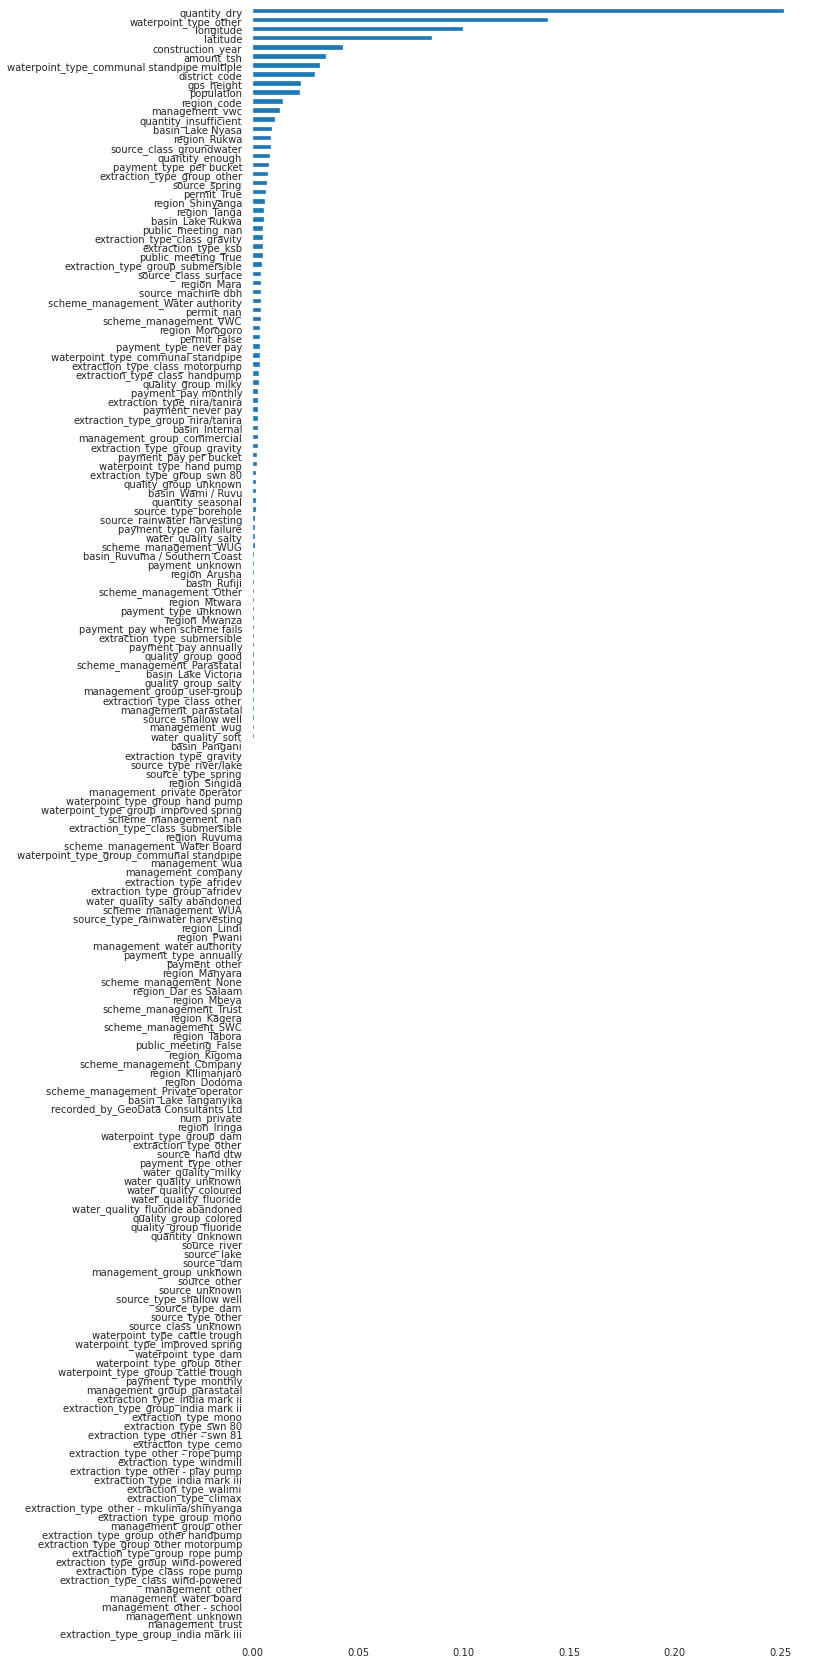

In [36]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10, 30))
importances.sort_values().plot.barh()

In [45]:
# Creating dataframe with predicted values
predictions = test.copy()
predictions['status_group'] = y_pred
predictions.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,functional
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,functional
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,non functional
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional


In [50]:
# Creating submission dataframe
my_submission = predictions[['id', 'status_group']]
my_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
# Downloading .csv file with submission data
my_submission.to_csv('my_submission.csv', index=False)
from google.colab import files
files.download('my_submission.csv')